## Anomaly detection in Payments using ML

#import Libraries

In [1]:
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.neighbors import KDTree

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Loading & Visulization

In [13]:
data=pd.read_csv(r'/content/drive/My Drive/creditcard.csv') 
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We can see above that there are 28 PCA components provided to us as it is not appropriate to provide someone's private details in dataset. Here We have another 2 features-Time and Amount. So there are total 30 features in our dataset. Label is provided to each Transaction i.e 0 for normal transaction and 1 for fraud transaction.

Time :- Number of seconds elapsed between this transaction and the first transaction in the dataset

Checking whether there is any missing value.


In [6]:
data.isnull().values.any()

False

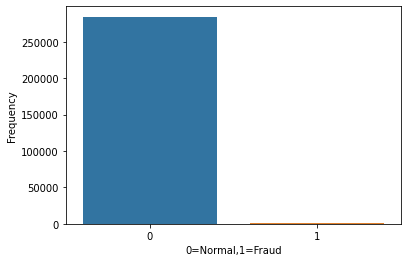

In [10]:
sns.countplot(x="Class",data=data)
plt.xlabel("0=Normal,1=Fraud")
plt.ylabel("Frequency")
plt.show()

In [12]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]
print("Number of fraud transactions :", len(fraud))
print("Number of normal transactions :", len(normal))
outlier_fraction = len(fraud)/float(len(normal))
print("Outlier Fraction:",outlier_fraction)

Number of fraud transactions : 492
Number of normal transactions : 284315
Outlier Fraction: 0.0017304750013189597


We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

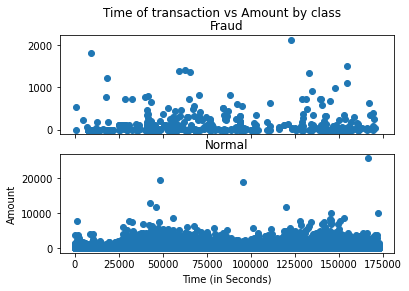

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

We Will check Do fraudulent transactions occur more often for certain amount ? Let us find out with a visual representation.

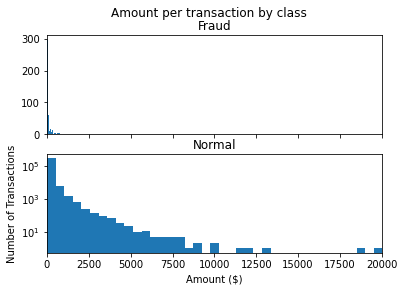

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Description of Fraudulent transactions

In [28]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [0]:
x=data.iloc[1:, 1:29]     
y=data.iloc[1:,30]

In [0]:
x=(x-np.mean(x))/np.std(x)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

#Logistic Regression

In [0]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
         # lr : Learning Rate
         # num_iter : Number of Iterations
         # fit_intercept : Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    # add column for intercept
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    # Sigmond Function
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # training function
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        # Gradient descent
        for _ in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
    # test function
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()

In [0]:
# LR training
model_lr = LogisticRegression(lr=0.01, num_iter=1000)
model_lr.fit(x_train, y_train)

In [44]:
y_lr = model_lr.predict(x_test)
error_lr = (y_lr != y_test).sum()
print("Number of Error : ",error_lr)

Number of Error :  72


In [45]:
y = np.array(y_test)
y_pred = np.array(y_lr)

right,wrong1,wrong2,total=0,0,0,0

for i in range(len(y_pred)):
  if(y_pred[i]==1 and y[i]==1):
    right=right+1
  if(y_pred[i]==1 and y[i]==0):
    wrong1=wrong1+1
  if(y_pred[i]==0 and y[i]==1):
    wrong2=wrong2+1
  if(y[i]==1):
    total=total+1


print("Number of fruad : ",total)
print("Number of Frauds detected : ",right + wrong1)
print("Number of Frauds detected as Normal Transaction: ",wrong2)

print("Accuracy : ",right/total)
print("Detection Ratio: ",(right+wrong1)/total)

Number of fruad :  112
Number of Frauds detected :  64
Number of Frauds detected as Normal Transaction:  60
Accuracy :  0.4642857142857143
Detection Ratio:  0.5714285714285714


#SVM

In [0]:

class SVM():
    
    #Simple implementation of a Support Vector Machine using the Sequential Minimal Optimization (SMO) algorithm for training.

    def __init__(self, max_iter=10000, C=1.0, epsilon=0.001):
        self.max_iter = max_iter
        self.C = C
        self.epsilon = epsilon

    def fit(self, X, y):
        # Initialization
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        count = 0
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i = X.values[i,:]
                x_j = X.values[j,:]
                y_i = y.values[i]
                y_j = y.values[j]

                x_i = x_i.reshape(1, -1)  # only one sample
                x_j = x_j.reshape(1, -1)

                k_ij = rbf_kernel(x_i, x_i) + rbf_kernel(x_j, x_j) - 2 * rbf_kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        # Compute final model parameters
        self.b = self.calc_b(X, y, self.w)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X.values[alpha_idx, :]
        return support_vectors, count


    def predict(self, X):
        return self.h(X, self.w, self.b)


    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)


    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))


    # Prediction
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)


    # Prediction error
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k


    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))


    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i

#Isolation Forest

In [0]:
import numpy as np
import pandas as pd
import random

class IsolationTreeEnsemble:

    def __init__(self, sample_size, n_trees=10):
        self.sample_size = sample_size
        self.n_trees = n_trees
        self.height_limit = np.log2(sample_size)
        self.trees = []

    def fit(self, X:np.ndarray):
        if isinstance(X, pd.DataFrame):
            X = X.values
            len_x = len(X)
            col_x = X.shape[1]
            self.trees = []
        for i in range(self.n_trees):
          sample_idx = random.sample(list(range(len_x)), self.sample_size)
          temp_tree = IsolationTree(self.height_limit, 0).fit(X[sample_idx, :])
          self.trees.append(temp_tree)
        return self

    def path_length(self, X:np.ndarray) -> np.ndarray:
        pl_vector = []
        if isinstance(X, pd.DataFrame):
            X = X.values
        for x in (X):
            pl = np.array([path_length_tree(x, t, 0) for t in self.trees])
            pl = pl.mean()
            pl_vector.append(pl)
        pl_vector = np.array(pl_vector).reshape(-1, 1)
        return pl_vector

    def anomaly_score(self, X:np.ndarray) -> np.ndarray:
        """
        Given a 2D matrix of observations, X, compute the anomaly score
        for each x_i observation, returning an ndarray of them.
        """
        return 2.0 ** (-1.0 * self.path_length(X) / c(len(X)))

    def predict_from_anomaly_scores(self, scores:np.ndarray, threshold:float) -> np.ndarray:
        """
        Given an array of scores and a score threshold, return an array of
        the predictions: 1 for any score >= the threshold and 0 otherwise.
        """

        predictions = [1 if p[0] >= threshold else 0 for p in scores]

        return predictions
        
    def predict(self, X:np.ndarray, threshold:float) -> np.ndarray:
        if isinstance(X, pd.DataFrame):
            X = X.values
        scores = 2.0 ** (-1.0 * self.path_length(X) / c(len(X)))
        predictions = [1 if p[0] >= threshold else 0 for p in scores]
        return predictions



class IsolationTree:

    def __init__(self, height_limit, current_height):
        self.height_limit = height_limit
        self.current_height = current_height
        self.split_by = None
        self.split_value = None
        self.right = None
        self.left = None
        self.size = 0
        self.exnodes = 0
        self.n_nodes = 1

    def fit(self, X:np.ndarray):
        if len(X) <= 1 or self.current_height >= self.height_limit:
            self.exnodes = 1
            self.size = X.shape[0]
            return self
        split_by = random.choice(np.arange(X.shape[1]))
        X_col = X[:, split_by]
        min_x = X_col.min()
        max_x = X_col.max()
        if min_x == max_x:
            self.exnodes = 1
            self.size = len(X)
            return self
        else:
            split_value = min_x + random.betavariate(0.5, 0.5) * (max_x - min_x)
            w = np.where(X_col < split_value, True, False)
            del X_col
            self.size = X.shape[0]
            self.split_by = split_by
            self.split_value = split_value
            self.left = IsolationTree(self.height_limit, self.current_height + 1).fit(X[w])
            self.right = IsolationTree(self.height_limit, self.current_height + 1).fit(X[~w])
            self.n_nodes = self.left.n_nodes + self.right.n_nodes + 1
        return self

def c(n):
    if n > 2:
        return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))
    elif n == 2:
        return 1
    if n == 1:
        return 0

def path_length_tree(x, t,e):
    e = e
    if t.exnodes == 1:
        e = e+ c(t.size)
        return e
    else:
        a = t.split_by
        if x[a] < t.split_value :
            return path_length_tree(x, t.left, e+1)

        if x[a] >= t.split_value :
            return path_length_tree(x, t.right, e+1)

In [49]:
it = IsolationTreeEnsemble(sample_size=512, n_trees=100)
it.fit(x_train)

In [0]:
scores = it.anomaly_score(x)
y_pred = it.predict_from_anomaly_scores(scores, 0.7)

In [54]:
y=np.array(y)
y_pred=np.array(y_pred)

for i in range(len(y_pred)):
  if(y_pred[i]==1 and y[i]==1):
    right=right+1
  if(y_pred[i]==1 and y[i]==0):
    wrong1=wrong1+1
  if(y_pred[i]==0 and y[i]==1):
    wrong2=wrong2+1
  if(y[i]==1):
    total=total+1


print("Number of fruad : ",total)
print("Number of Frauds detected : ",right + wrong1)
print("Number of Normal Transaction detected as Fraud : ",wrong1)
print("Number of Frauds detected as Normal Transaction: ",wrong2)

print("Accuracy : ",right/total)
print("Detection Ratio: ",(right+wrong1)/total)

Number of fruad :  716
Number of Frauds detected :  6846
Number of Normal Transaction detected as Fraud :  6403
Number of Frauds detected as Normal Transaction:  273
Accuracy :  0.6187150837988827
Detection Ratio:  9.561452513966481


#Local Outlier Factor (LOF)

In [0]:
def LocalOutlierFactor(X, k, outlier_threshold = 1.2):

    # KDtree is a space-partitioning data structure for organizing points in a k-dimensional space. 
    # X = dataset, leaf_size = Number of points at which to switch to brute-force. , p = 2 means a euclidean distance metric
    BT = KDTree(X, leaf_size=k, p=2)

    distance, index = BT.query(X, k)
    distance, index = distance[:, 1:], index[:, 1:] 
    radius = distance[:, -1]

    #Calculate Local Reachability Distance.
    LRD = np.mean(np.maximum(distance, radius[index]), axis=1)
    r = 1. / np.array(LRD)

    #Calculate outlier score.
    outlier_score = np.sum(r[index], axis=1) / np.array(r, dtype=np.float16)
    outlier_score *= 1. / k

    # target class
    y = []

    # check whether given instance in outlier or not based on their outlier_score and outlier_threshold
    for i, score in enumerate(outlier_score):
        if score > outlier_threshold:
            y.append(1)
        else :
            y.append(0)

    return y

In [0]:
y_lof = LocalOutlierFactor(x, k=10, outlier_threshold = 3)
print(accuracy_score(y,y_lof))